In [1]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer
from qiskit.tools.visualization import circuit_drawer,plot_distribution,plot_state_city
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()


In [2]:
sim = Aer.get_backend('qasm_simulator')
hanoi = provider.get_backend('ibm_hanoi')
cusco = provider.get_backend('ibm_cusco')
mumbai = provider.get_backend('ibmq_mumbai')
cairo = provider.get_backend('ibm_cairo')
kyoto = provider.get_backend('ibm_kyoto')
algiers = provider.get_backend('ibm_algiers')

In [3]:
def make_chsh_circuit(theta_vec,change):

    chsh_circuits = []
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            ar1 = QuantumRegister(1,"aqu1")
            qr1 = QuantumRegister(2,"dqu1")
            qr2 = QuantumRegister(1,"dqu2")
            ar3 = QuantumRegister(1,"aqu3")
            fa_2 = ClassicalRegister(1)
            fa_3 = ClassicalRegister(1)
            a_2 = ClassicalRegister(1)
            a_3 = ClassicalRegister(1)
            a_4 = ClassicalRegister(1)
            a_5 = ClassicalRegister(1)
            qc = QuantumCircuit(ar1,qr1,qr2,ar3,fa_3,a_2,a_3,a_4,a_5)
            #スタビライザZZ1
            if change =="1":
                qc.h(1)
                qc.cx(1,2)
            elif change =="2":
                qc.h(0)
                qc.cx(0,1)
                qc.swap(0,2)
            else:
                qc.h(1)
                qc.h(2)
                qc.cx(1,0)
                qc.cx(2,0)
                qc.measure(0,fa_3)
                with qc.if_test((fa_3, 1)):
                    qc.x(1)
            #スタビライザZZ2
            qc.barrier()
            #ロジカルCX
            qc.cx(1,3)
            qc.cx(2,4)
            qc.barrier()
            #ロジカルRY
            qc.sdg(1)
            qc.rxx(theta,1,2)
            qc.s(1)
            qc.barrier()
            if el == '01':
                qc.h(3)
                qc.h(4)
            elif el=='10':
                qc.h(1)
                qc.h(2)
            elif el =='11':
                qc.h(1)
                qc.h(2)
                qc.h(3)
                qc.h(4)
            qc.barrier()
            qc.measure(0,fa_3)
            qc.measure(1,a_2)
            qc.measure(2,a_3)
            qc.measure(3,a_4)
            qc.measure(4,a_5)
            chsh_circuits.append(qc)
    return chsh_circuits


In [4]:
def compute_chsh_witness(counts):
    # Order is ZZ,ZX,XZ,XX
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]
        no_shots = sum(xx[y] for y in xx)
        chsh1 = 0
        chsh2 = 0
        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2

In [5]:
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits1 = make_chsh_circuit(theta_vec,"1")
my_chsh_circuits2 = make_chsh_circuit(theta_vec,"2")
my_chsh_circuits3 = make_chsh_circuit(theta_vec,"3")

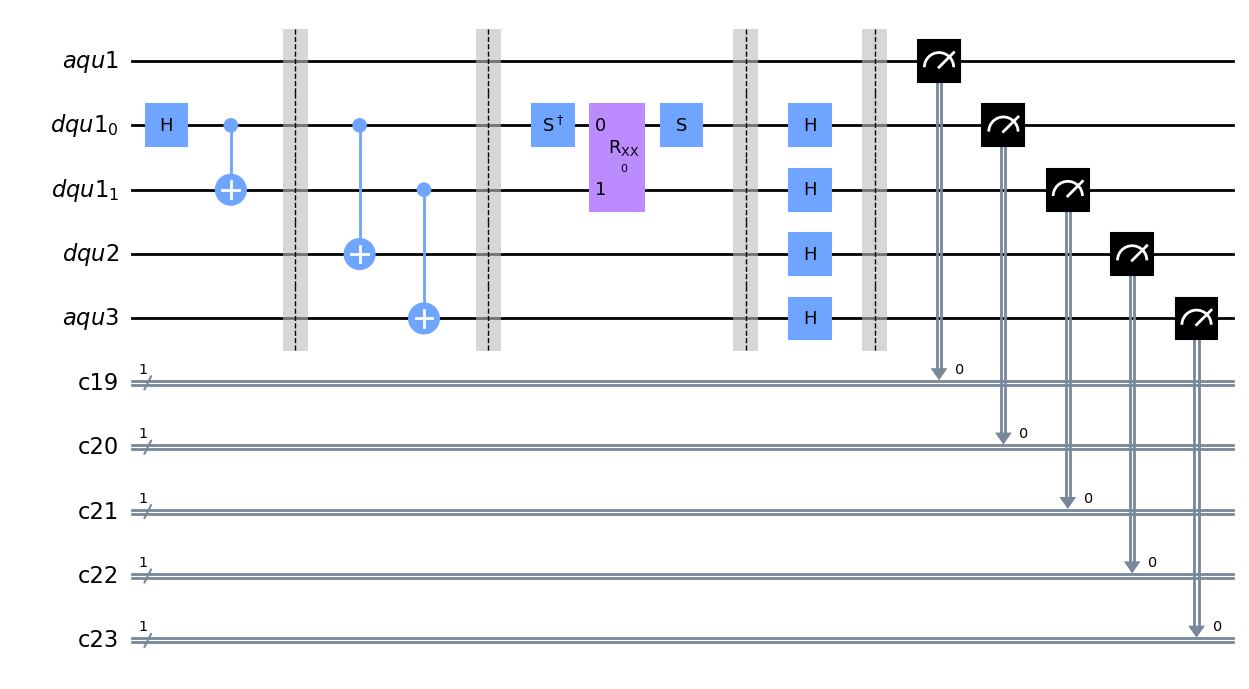

In [6]:
my_chsh_circuits1[3].draw("mpl")

In [7]:
# シュミレーター実行
result_ideal = sim.run(my_chsh_circuits1,shots=8000).result()
# 実機のバックエンドでの実行に最適な回路に変換
qc_compiled1 = transpile(my_chsh_circuits1, cairo, initial_layout=[17,18,21,15,23])
qc_compiled2 = transpile(my_chsh_circuits2, cairo, initial_layout=[17,18,21,15,23])
qc_compiled3 = transpile(my_chsh_circuits3, cairo, initial_layout=[17,18,21,15,23])
#result_real1 = cairo.run(qc_compiled1, shots=8000,dynamic=True).result()
#result_real2 = cairo.run(qc_compiled2, shots=8000,dynamic=True).result()
#result_real3 = cairo.run(qc_compiled3, shots=8000,dynamic=True).result()


In [9]:
def convert_pair_Z(pair):
    if pair == '0 0 ':
        return '0'
    elif pair == '1 1 ':
        return '1'
    else:
        return '2'
def convert_pair_X(pair):
    #ZX
    if pair == '1 0 ':
        return '1'
    elif pair == '1 1 ':
        return '0'
    elif pair == '0 0 ':
        return '0'
    elif pair == '0 1 ':
        return '1'
    else:
        return '2'

def convert_key_ZZ(key):
    # 末尾の2桁を削除
    key = key[:-1]
    # 残りの4桁を2桁ずつに分ける
    first_pair = key[:4]
    second_pair = key[4:]
    # 各ペアを変換
    # 変換結果を結合
    return convert_pair_Z(first_pair) + convert_pair_Z(second_pair)

def convert_key_ZX(key):
    # 末尾の2桁を削除
    key = key[:-1]
    # 残りの4桁を2桁ずつに分ける
    first_pair = key[:4]
    second_pair = key[4:]
    # 各ペアを変換
    return convert_pair_Z(first_pair) + convert_pair_X(second_pair)

def convert_key_XZ(key):
    # 末尾の2桁を削除
    key = key[:-1]
    # 残りの4桁を2桁ずつに分ける
    first_pair = key[:4]
    second_pair = key[4:]
    # 各ペアを変換
    return convert_pair_X(first_pair) + convert_pair_Z(second_pair)

def convert_key_XX(key):
    # 末尾の2桁を削除
    key = key[:-1]
    # 残りの4桁を2桁ずつに分ける
    first_pair = key[:4]
    second_pair = key[4:]
    # 各ペアを変換
    # 変換結果を結合
    return convert_pair_X(first_pair) + convert_pair_X(second_pair)

In [10]:
def convert_dict(dictionary,index):
    new_dict = {}
    for key, val in dictionary.items():
        if index % 4 ==0:
            new_key = convert_key_ZZ(key)
        elif index % 4 ==1:
            new_key = convert_key_XZ(key)
        elif index % 4 ==2:
            new_key = convert_key_ZX(key)
        else:
            new_key = convert_key_XX(key)
        if new_key in new_dict:
            new_dict[new_key] += val  # 同じキーの値を合計する
        else:
            new_dict[new_key] = val
    return new_dict

result_ideal_count = result_ideal.get_counts()
result_real_count1 = result_real1.get_counts()
result_real_count2 = result_real2.get_counts()
result_real_count3 = result_real3.get_counts()
# 変換された結果
converted_results_ideal = [convert_dict(dictionary,i) for i, dictionary in enumerate(result_ideal_count)]
converted_results_real1 = [convert_dict(dictionary,i) for i, dictionary in enumerate(result_real_count1)]
converted_results_real2 = [convert_dict(dictionary,i) for i, dictionary in enumerate(result_real_count2)]
converted_results_real3 = [convert_dict(dictionary,i) for i, dictionary in enumerate(result_real_count3)]


In [14]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(converted_results_ideal)
CHSH1_real1, CHSH2_real1 = compute_chsh_witness(converted_results_real1)
CHSH1_real2, CHSH2_real2 = compute_chsh_witness(converted_results_real2)
CHSH1_real3, CHSH2_real3 = compute_chsh_witness(converted_results_real3)


2.793


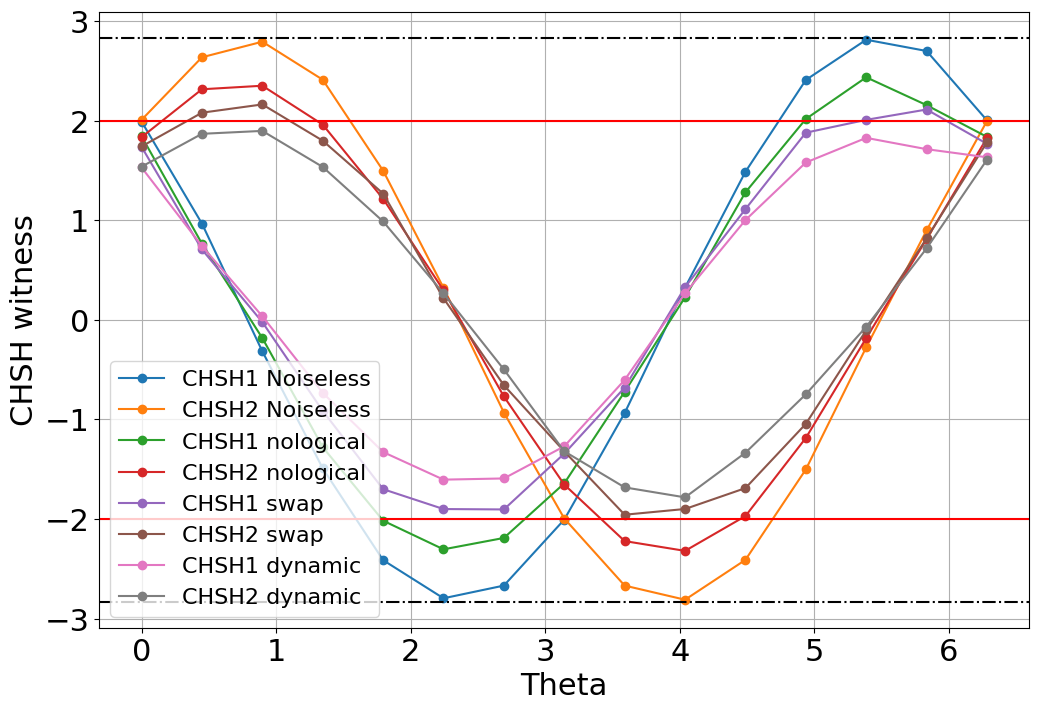

In [12]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')
plt.plot(theta_vec,CHSH1_real1,'o-',label = 'CHSH1 nological')
plt.plot(theta_vec,CHSH2_real1,'o-',label = 'CHSH2 nological')
plt.plot(theta_vec,CHSH1_real2,'o-',label = 'CHSH1 swap')
plt.plot(theta_vec,CHSH2_real2,'o-',label = 'CHSH2 swap')
plt.plot(theta_vec,CHSH1_real3,'o-',label = 'CHSH1 dynamic')
plt.plot(theta_vec,CHSH2_real3,'o-',label = 'CHSH2 dynamic')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.savefig('LCHSH_nological.pdf',format="pdf")